#### Imports

In [1]:
import cv2
import os
import numpy as np
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Masking, Dropout, BatchNormalization,Bidirectional
from sklearn.decomposition import PCA

#### Face Detection Options

In [2]:
BaseOptions = mp.tasks.BaseOptions
FaceDetector = mp.tasks.vision.FaceDetector
FaceDetectorOptions = mp.tasks.vision.FaceDetectorOptions
VisionRunningMode = mp.tasks.vision.RunningMode

# Create a face detector instance with the video mode:
detector_options = FaceDetectorOptions(
    base_options=BaseOptions(model_asset_path='./models/detector.tflite'),
    running_mode=VisionRunningMode.VIDEO)

In [73]:
def edge_detection(vid_path, fps, t_lower, t_upper):
    video = cv2.VideoCapture(vid_path)
    original_fps = video.get(cv2.CAP_PROP_FPS)

    if fps > original_fps:
        interval = 1
    else:
        interval = int(original_fps / fps)

    frame_count = 0

    edge_diffs = []
    timestamps = []

    previous_frame = None

    with FaceDetector.create_from_options(detector_options) as detector:

        while video.isOpened():
            ret, frame = video.read()

            if not ret:
                break

            if frame_count % interval == 0:
                # timestamp
                frame_timestamp = int(video.get(cv2.CAP_PROP_POS_MSEC))
                #frame
                frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                mp_frame = mp.Image(image_format=mp.ImageFormat.SRGB, data=frame_rgb)
                # detect
                detect = detector.detect_for_video(mp_frame, frame_timestamp)

                if detect.detections:

                    for detection in detect.detections:
                        bbox = detection.bounding_box
                        start_x = int(bbox.origin_x)
                        start_y = int(bbox.origin_y)
                        end_x = int(bbox.origin_x + ((bbox.width*0.1) + bbox.width))
                        end_y = int(bbox.origin_y + ((bbox.height*0.1)+bbox.height))
                        
                        # Crop the face region
                        current_frame = frame[start_y:end_y, start_x:end_x]

                        if previous_frame is not None:
                            current_frame_resized = cv2.resize(current_frame, (previous_frame.shape[1], previous_frame.shape[0]))
                            # Compare edges across consecutive frames
                            edges_prev = cv2.Canny(previous_frame, t_lower, t_upper)
                            edges_curr = cv2.Canny(current_frame_resized, t_lower, t_upper)
                            diff = cv2.absdiff(edges_prev, edges_curr)

                            # # Flatten the frame and normalize
                            diff_flat = diff.flatten() / 255.0

                            # Store the flattened edge difference and timestamp
                            edge_diffs.append(diff_flat)
                            
                            timestamps.append(frame_timestamp)

                            # cv2.imshow('Edge Difference', diff)

                        previous_frame = current_frame


                if len(edge_diffs) > 14: # get the first 15 frames only
                    break
            # Add a delay and exit mechanism
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break

            frame_count += 1

        video.release()
        cv2.destroyAllWindows()


    if edge_diffs:
        max_length = max(len(diff) for diff in edge_diffs)
        edge_diffs = [np.pad(diff, (0, max_length - len(diff)), 'constant') for diff in edge_diffs]

    # Convert to numpy array
    edge_diffs = np.array(edge_diffs)
    
    # Apply PCA
    # pca = PCA(n_components=15)
    # edge_diffs_reduced = pca.fit_transform(edge_diffs)

    timestamps = np.array(timestamps)
    timestamps = timestamps.reshape(-1,1)   
    combined = np.hstack((edge_diffs, timestamps))
        
    return combined




In [74]:
x = edge_detection(vid_path='./test_data/originals/001.mp4', fps=15, t_lower=50, t_upper=150)

In [76]:
print(x.shape)

(15, 36482)


In [58]:
def load_data(originals, deepfakes, fps, t_lower, t_upper):
    X_edge_differences = [] 
    y = []

    for video_path in os.listdir(originals):
        relative_path = os.path.join(originals, video_path)
        result = edge_detection(vid_path=relative_path, fps=fps, t_lower=t_lower, t_upper=t_upper)
        if result.size == 0:
            continue 
        print(f"Original video {video_path} result shape: {result.shape}")
        X_edge_differences.append(result)
        y.append(0)
    
    print("ORIGINALS DONEEEEE")

    for video_path in os.listdir(deepfakes):
        relative_path = os.path.join(deepfakes, video_path)
        
        result = edge_detection(vid_path=relative_path, fps=fps, t_lower=t_lower, t_upper=t_upper)
        if result.size == 0:
            continue 
        print(f"Deepfake video {video_path} result shape: {result.shape}")
        X_edge_differences.append(result)
        
        y.append(1)

    # Find the maximum length of the second dimension
    max_length = max(result.shape[1] for result in X_edge_differences)
    print(f"Max length of second dimension: {max_length}")

    # Pad each element to ensure they all have the same shape
    X_edge_differences_padded = []
    for result in X_edge_differences:
        pad_width = max_length - result.shape[1]
        padded_result = np.pad(result, ((0, 0), (0, pad_width)), mode='constant')
        print(f"Padded result shape: {padded_result.shape}")
        X_edge_differences_padded.append(padded_result)


    return np.array(X_edge_differences_padded), np.array(y)

In [84]:
X, y = load_data(originals='./test_data/originals', deepfakes='./test_data/deepfakes', fps=15, t_lower=50, t_upper=150)

c:\dev\thesis2\deepfake_manipulation_detection\venv\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


Original video 000.mp4 result shape: (15, 18497)
Original video 001.mp4 result shape: (15, 36482)
Original video 002.mp4 result shape: (15, 60026)
Original video 003.mp4 result shape: (15, 13226)
Original video 004.mp4 result shape: (15, 38417)
Original video 005.mp4 result shape: (15, 14642)
Original video 006.mp4 result shape: (15, 63002)
Original video 007.mp4 result shape: (15, 8465)
Original video 008.mp4 result shape: (15, 10001)
Original video 009.mp4 result shape: (15, 36482)
Original video 010.mp4 result shape: (15, 13226)
Original video 011.mp4 result shape: (15, 71825)
Original video 012.mp4 result shape: (15, 12997)
Original video 013.mp4 result shape: (15, 19045)
Original video 014.mp4 result shape: (15, 10817)
Original video 016.mp4 result shape: (15, 10817)
Original video 017.mp4 result shape: (15, 72901)
Original video 018.mp4 result shape: (15, 17957)
Original video 019.mp4 result shape: (15, 24337)
Original video 020.mp4 result shape: (15, 76730)
Original video 021.mp

In [85]:
print(X.shape, y.shape)

(0,) (248,)


In [86]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

ValueError: Found input variables with inconsistent numbers of samples: [0, 248]

In [64]:
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_test: {y_test.shape}")

Shape of X_train: (196, 15, 16)
Shape of y_train: (196,)
Shape of X_test: (50, 15, 16)
Shape of y_test: (50,)


In [51]:
# Define the enhanced LSTM model
model2 = Sequential()

# Add LSTM layers with more units and dropout for regularization
model2.add(LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model2.add(Dropout(0.2))
model2.add(LSTM(64, return_sequences=False))
model2.add(Dropout(0.2))

# Add a Batch Normalization layer
model2.add(BatchNormalization())

# Add Dense layers with Dropout
model2.add(Dense(64, activation='relu'))
model2.add(Dropout(0.2))
model2.add(Dense(32, activation='relu'))
model2.add(Dropout(0.2))
model2.add(Dense(1, activation='sigmoid'))

# Compile the model
model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print the model summary
model2.summary()

c:\dev\thesis2\deepfake_manipulation_detection\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 15, 128)        │        74,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 15, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 130,177 (508.50 KB)

 Trainable params: 130,049 (508.00 KB)

 Non-trainable params: 128 (512.00 B)

In [68]:
    history = model2.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=1)

Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9612 - loss: 0.1208 - val_accuracy: 0.8000 - val_loss: 0.6042
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9836 - loss: 0.0571 - val_accuracy: 0.6750 - val_loss: 0.6662
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9750 - loss: 0.0649 - val_accuracy: 0.7500 - val_loss: 0.6269
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9818 - loss: 0.0791 - val_accuracy: 0.7500 - val_loss: 0.6830
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9966 - loss: 0.0260 - val_accuracy: 0.6750 - val_loss: 0.8605
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9979 - loss: 0.0302 - val_accuracy: 0.6500 - val_loss: 0.8317
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 0.0280 - val_accuracy: 0.7250 - val_loss: 0.8493
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9922 - loss: 0.0423 - val_accuracy: 0.6750 - val_loss:

In [69]:
# Evaluate the model on the test set
test_loss, test_acc = model2.evaluate(X_test, y_test, verbose=1)
print(f'Test Accuracy: {test_acc}')

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5667 - loss: 3.5152 
Test Accuracy: 0.6000000238418579


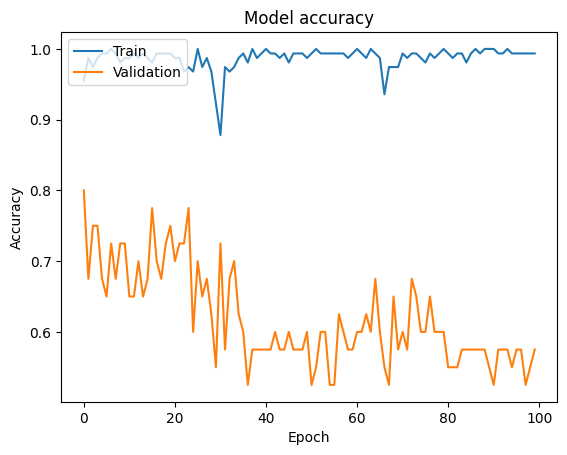

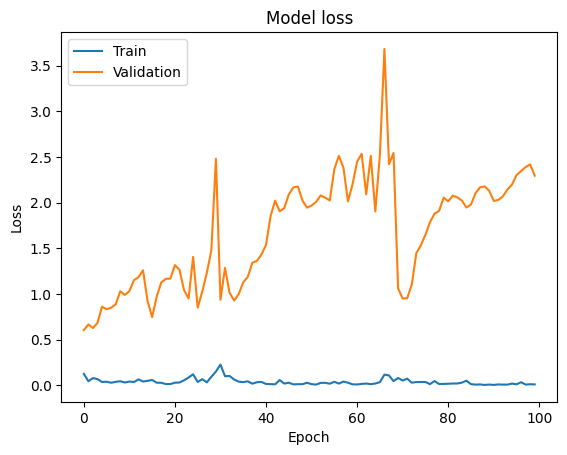

In [70]:
# Plot training & validation accuracy and loss
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [83]:
# Define the enhanced LSTM model
model2 = Sequential()

# Add Bidirectional LSTM layers with more units and dropout for regularization
model2.add(Bidirectional(LSTM(128, return_sequences=True), input_shape=(X_train.shape[1], X_train.shape[2])))
model2.add(Dropout(0.3))
model2.add(Bidirectional(LSTM(64, return_sequences=True)))
model2.add(Dropout(0.3))
model2.add(Bidirectional(LSTM(32, return_sequences=False)))
model2.add(Dropout(0.3))

# Add a Batch Normalization layer
model2.add(BatchNormalization())

# Add Dense layers with Dropout
model2.add(Dense(128, activation='relu'))
model2.add(Dropout(0.3))
model2.add(Dense(64, activation='relu'))
model2.add(Dropout(0.3))
model2.add(Dense(32, activation='relu'))
model2.add(Dropout(0.3))
model2.add(Dense(1, activation='sigmoid'))

# Compile the model
model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print the model summary
model2.summary()

c:\dev\thesis2\deepfake_manipulation_detection\venv\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 15, 256)        │       148,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 15, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 15, 128)        │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 15, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 64)             │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 372,993 (1.42 MB)

 Trainable params: 372,865 (1.42 MB)

 Non-trainable params: 128 (512.00 B)